In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import os

import helper_functions as helper

In [3]:
with open('data_path.txt', 'r') as f:
    data_path = os.path.join(f.readline(), 'steering')

file_path = os.path.join(data_path, 'MarkkulaEtAl_BiolCyb2018_DataWithIntermittentInterpretation.mat')
data = helper.loadmat(file_path)

sightpoint_filepath = os.path.join(data_path, 'PreCalculatedSightPointSignalData.mat')
sightpoint_data = helper.loadmat(sightpoint_filepath)['SSightPointPreCalc']

lk_data = data['STasks'][0]
lk_sightpoint_data = sightpoint_data.STasks[0]
lk_subjects = np.arange(1, 16)

cd_data = data['STasks'][1]
cd_sightpoint_data = sightpoint_data.STasks[1]
cd_subjects = np.arange(1, 9)

# Prepare passive phase data

In [54]:
def get_p(sightpoint_recording, p_weights):
    near_sightpoint = (sightpoint_recording.SSightPointPreviewTimes[0].SPathVariants.SSightPointSignals)
    nsp_angle = near_sightpoint.VSightPointAngle
    nsp_rate = near_sightpoint.VSightPointRate

    far_sightpoint = (sightpoint_recording.SSightPointPreviewTimes[1].SPathVariants.SSightPointSignals)
    fsp_angle = far_sightpoint.VSightPointAngle
    fsp_rate = far_sightpoint.VSightPointRate
    
    p = p_weights['k_nI']*nsp_angle + p_weights['k_nP']*nsp_rate + p_weights['k_f']*fsp_rate
    
    return p

def get_passive_phase_data(data, sightpoint_data, p_weights, delay):
    passive_phases = []
    for i, driver in enumerate(data.SDrivers):
        for j, recording in enumerate(driver.SRecordings):
            # Option 1: steering wheel angular velocity from the original data
#             v = recording.SSignals.VSWRate

            # Option 2: VSWRate might be a bit oversmoothed, which might lead to underestimation of 
            # inter-adjustment intervals, so we try an alternative numerical differentiation algo here
            v = helper.differentiate(recording.SSignals.VTimeStamp, recording.SSignals.VSWAngle)
            
            # Also, here we'll try out a custom adjustment onset extraction algorithm I used for the stick data
            # It will miss adjustments initiated in the middle of preceding adjustment, but the thing
            # is, if we are to analyze inter-adjustment intervals, these are not well-defined here,
            # so I believe it's better to treat multi-movement corrections as a single adjustment
            starting_points, action_points = helper.extract_passive_phases(v)

            # we're looking at passive phases, so sensorimotor delays supposedly affect action points
            # but not starting points of passive phases. The reason is that corrective adjustments are open-loop,
            # so their final part doesn't depend on the system state. However, the end of a passive phase
            # (action point) is driven by the system state, supposedly delayed
            
            # in the lane-keeping task sampling frequency was 60Hz (time step 16.7ms)
            delay_n = int(round(delay/16.7))
            
            delayed_ap = np.array(action_points) - delay_n
            delayed_ap[delayed_ap<=0] = 0
            
            t_sp = recording.SSignals.VTimeStamp[starting_points]
            t_ap = recording.SSignals.VTimeStamp[delayed_ap]
            
            p = get_p(sightpoint_data.SDrivers[i].SRecordings[j], p_weights)

            df = pd.DataFrame({'subject': i+1,
                               'recording': j+1,
                               'passive_phase_number': np.arange(1, len(starting_points)+1),
                               'idx_sp': starting_points,
                               'idx_ap': action_points,
                               't_sp': t_sp, 
                               't_ap': t_ap,
                               'p_sp': abs(p[starting_points]),
                               'p_ap': abs(p[delayed_ap])})
            
            passive_phases.append(df)
    
    passive_phases = pd.concat(passive_phases).set_index(['subject', 'recording'], drop=False)
    
    passive_phases['delta_t'] = passive_phases.t_ap - passive_phases.t_sp
    passive_phases = passive_phases[passive_phases.delta_t>0]
    passive_phases['log_delta_t'] = np.log(passive_phases.delta_t)   
    passive_phases['log_p_sp'] = np.log(passive_phases.p_sp)
    passive_phases['p_sp_decile'] = pd.qcut(passive_phases['p_sp'], 10, labels=np.arange(1,11))
    return passive_phases

def save_passive_phases_to_csv(data, sightpoint_data, task, p_weights, delay):
    passive_phases = get_passive_phase_data(data, sightpoint_data, p_weights, delay)
    passive_phases.to_csv(os.path.join(data_path, 'passive_phases_%s.csv' % (task)), index=False)

In [55]:
p_weights = {'k_nI': 0.02, 'k_nP': 0.2, 'k_f': 1.6}
delay = 0 #ms

save_passive_phases_to_csv(lk_data, lk_sightpoint_data, 'lk', p_weights, delay)
# save_passive_phases_to_csv(cd_data, cd_sightpoint_data, 'cd', p_weights)

# Check passive phase data

In [56]:
passive_phases_lk = pd.read_csv(os.path.join(data_path, 'passive_phases_lk.csv'), index_col=None)
# passive_phases_cd = pd.read_csv(os.path.join(data_path, 'passive_phases_cd.csv'), index_col=None)

# there is an outlier in the circular driving task, better exclude it
# print(passive_phases_cd[passive_phases_cd.p_sp>2])
# passive_phases_cd = passive_phases_cd[passive_phases_cd.p_sp<2]

In [57]:
len(passive_phases_lk)

2276

In [58]:
len(passive_phases_lk[passive_phases_lk.delta_t<=0])

0

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


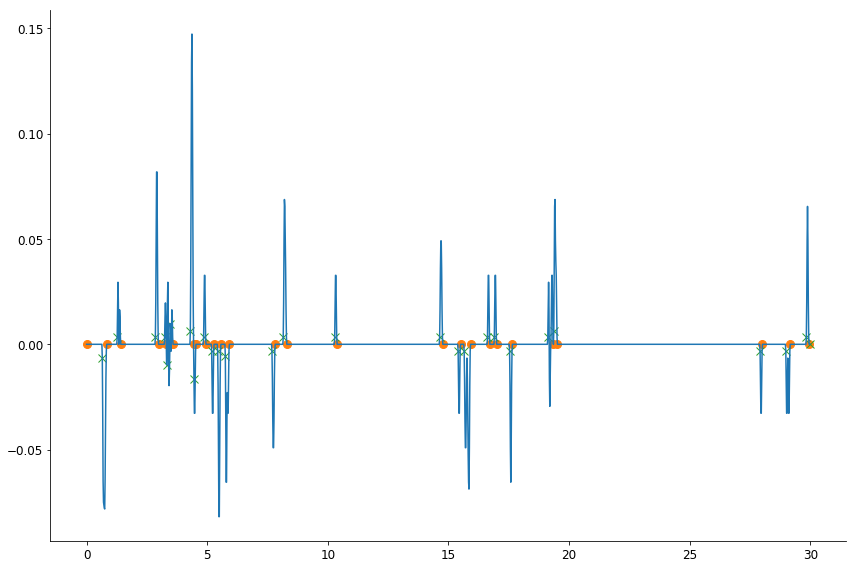

In [59]:
def plot_example_sw_rate(drivers, passive_phases, subject=1, recording=1):
    data = drivers.SDrivers[subject-1].SRecordings[recording-1]
    t = data.SSignals.VTimeStamp
    x = data.SSignals.VSWAngle
    v = helper.differentiate(t, x)

    ap_idx = passive_phases[(passive_phases.subject==subject) & (passive_phases.recording==recording)].idx_ap.values
    sp_idx = passive_phases[(passive_phases.subject==subject) & (passive_phases.recording==recording)].idx_sp.values

    fig, ax = plt.subplots(figsize=(12,8))    
    ax.plot(t[sp_idx], v[sp_idx], ls='', marker='o', ms=8, color='C1')
    ax.plot(t[ap_idx], v[ap_idx], ls='', marker='x', ms=8, color='C2')
    ax.plot(t, v)
#     ax.set_xlim([0,5])
    
plot_example_sw_rate(lk_data, passive_phases_lk, subject=1, recording=2)
# plot_example_sw_rate(cd_data, passive_phases_cd, subject=1, recording=2)

# Exploring $\Delta_t$ distributions

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


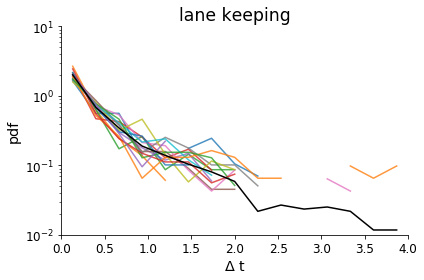

In [60]:
def plot_delta_t_hist(data, task, xlim):
    ax = helper.plot_pdf(data=data, var='delta_t', bins=np.linspace(0, xlim[1], 16))
#     ax = helper.plot_pdf(data=data, var='delta_t', bins=25)
    ax.set_xlabel('$\Delta$ t')
#     ax.set_ylabel('pdf')
    ax.set_xlim(xlim)
    ax.set_ylim((0.01, 10))
    ax.set_title(task)
    
    return ax
    
ax = plot_delta_t_hist(passive_phases_lk, 'lane keeping', (0., 4))
plt.savefig('figures/delta_t_pdf_lk.png')

# ax = plot_delta_t_hist(passive_phases_cd, 'circular driving', (0., 2))
# plt.savefig('figures/delta_t_pdf_cd.png')

# $p_{AP}$ distributions

(0.1, 500)

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


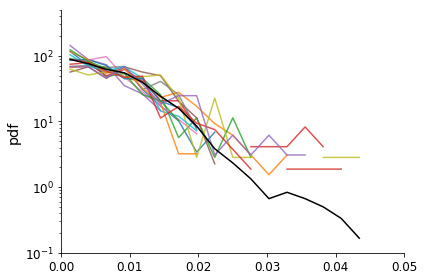

In [61]:
ax = helper.plot_pdf(data=passive_phases_lk, var='p_ap', bins=np.linspace(0, 0.05, 20))
ax.set_xlim((0.0, 0.05))
ax.set_ylim((0.1, 500))

# ax = helper.plot_pdf(data=passive_phases_cd, var='p_ap', bins=np.linspace(0, 0.3, 20))
# ax.set_xlim((0.0, 0.3))
# ax.set_ylim((0.05, 50))

# $p_{SP}$ distributions

(0.1, 500)

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


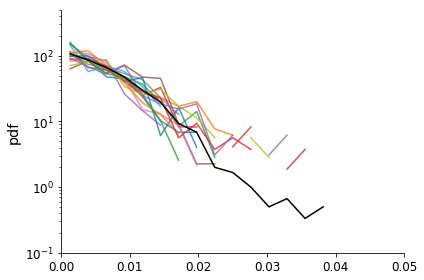

In [62]:
ax = helper.plot_pdf(data=passive_phases_lk, var='p_sp', bins=np.linspace(0, 0.05, 20))
ax.set_xlim((0.0, 0.05))
ax.set_ylim((0.1, 500))

# ax = helper.plot_pdf(data=passive_phases_cd, var='p_sp', bins=np.linspace(0, 0.3, 20))
# ax.set_xlim((0.0, 0.3))
# ax.set_ylim((0.05, 50))

# Joint $p_{SP}$ vs $\Delta_t$ distributions

Assuming $p_{SP}$ is driving the decision to start steering, how does the adjustment initiation time change with $p_{SP}$?

In the lane keeping task, $\Delta_t$ generally decreases with $p_{SP}$

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


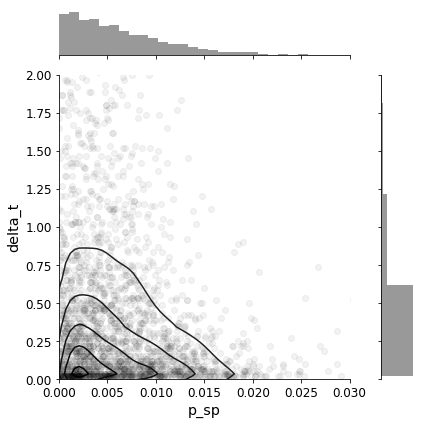

In [63]:
(sns.jointplot(x=passive_phases_lk.p_sp, y=passive_phases_lk.delta_t, alpha=0.05, xlim=(0, 0.03), ylim=(0, 2), color='k')
    .plot_joint(sns.kdeplot, zorder=10, n_levels=5, color='k'))

To make this clearer, we'll plot average $\Delta_t$ for every decile of $p_{SP}$.

In the lane keeping task, $\Delta_t$ decreases from about 700-800ms for the least pressing situations to about 200ms for situations where the $p_{SP}$ is very large already in the beginning of a passive phase.

C:\Users\Arkady\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


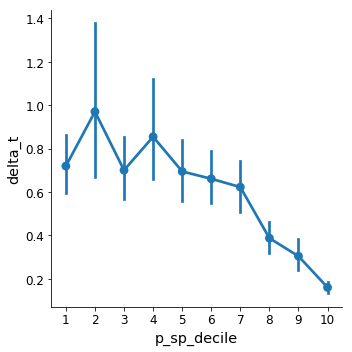

In [64]:
sns.factorplot(data=passive_phases_lk, x='p_sp_decile', y='delta_t', kind='point')

# Try looking at log-scaled $\Delta_t$ and $p_{SP}$?

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


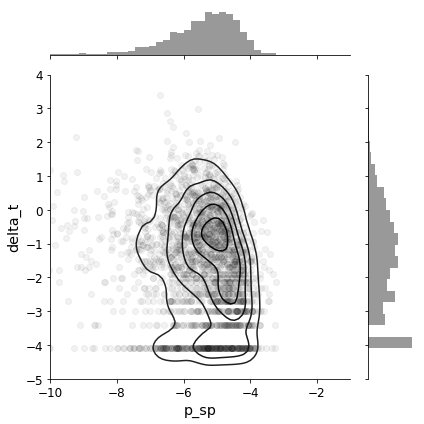

In [65]:
(sns.jointplot(x=np.log(passive_phases_lk[passive_phases_lk.p_sp>0].p_sp), 
               y=np.log(passive_phases_lk[passive_phases_lk.p_sp>0].delta_t), 
               xlim=(-10, -1), ylim=(-5, 4),
               alpha=0.05, color='k')
    .plot_joint(sns.kdeplot, zorder=10, n_levels=5, color='k'))

C:\Users\Arkady\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


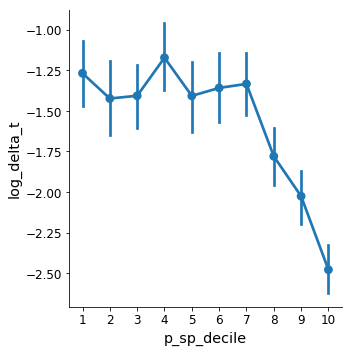

In [66]:
sns.factorplot(data=passive_phases_lk, x='p_sp_decile', y='log_delta_t', kind='point')
# sns.factorplot(data=passive_phases_cd, x='p_sp_decile', y='log_delta_t', kind='point')

# Dynamics of $p$ in the passive phase 

In [67]:
def get_p_dynamics(passive_phase, sightpoint_data):
    p_weights = {'k_nI': 0.02, 'k_nP': 0.2, 'k_f': 1.6}
    subject, recording = passive_phase.name[0]-1, passive_phase.name[1]-1
    p = get_p(sightpoint_data.SDrivers[subject].SRecordings[recording], p_weights=p_weights)
    
    return pd.Series(p[int(passive_phase.idx_sp):int(passive_phase.idx_ap)])
    
p_dynamics_lk = passive_phases_lk.groupby(['subject', 
                                           'recording', 
                                           'passive_phase_number']).apply(lambda p: 
                                                                          get_p_dynamics(p, lk_sightpoint_data))

# p_dynamics_cd = passive_phases_cd.groupby(['subject', 
#                                            'recording', 
#                                            'passive_phase_number']).apply(lambda p: 
#                                                                           get_p_dynamics(p, cd_sightpoint_data))

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


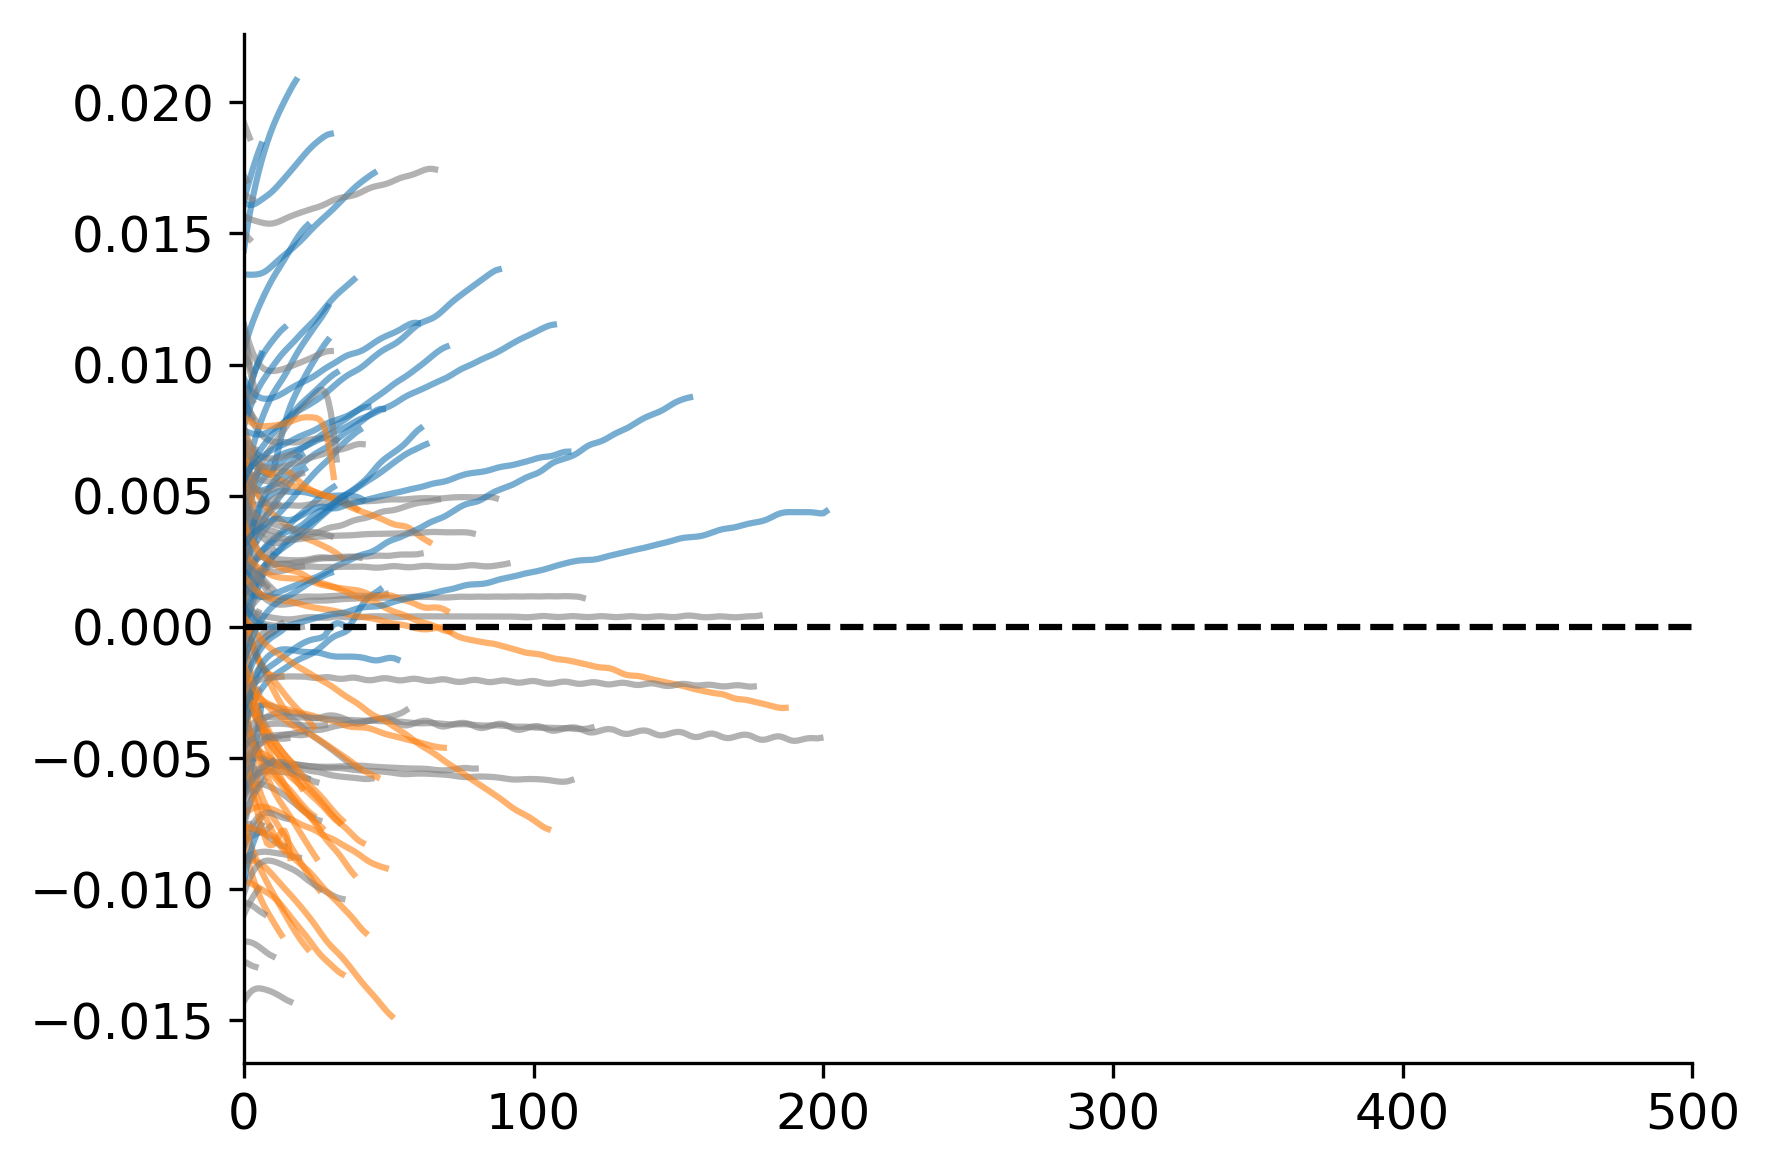

In [68]:
def plot_p(p_dynamics):
    threshold = 0.002
    if (p_dynamics[0] - p_dynamics[-1] < -threshold):
        color='C0'
    elif(p_dynamics[0] - p_dynamics[-1] > threshold):
        color='C1'
    else:
        color='grey'
            
    plt.plot(p_dynamics.values, color=color, alpha=0.6)

plt.figure(dpi=300)
p_dynamics_lk[7].groupby(['recording', 'passive_phase_number']).apply(plot_p);
plt.gca().set_xlim((0,500))
plt.gca().axhline(0.0, color='k', ls='--')

# DDM modeling

In [70]:
hdf_path = os.path.join(data_path, 'HDF')

def dx(A, c, dt):
    return A*dt + c*np.random.randn()*np.sqrt(dt)

# stimulus strength increases exponentially
def dtheta(theta, tau, dt):
    return theta*dt/tau
    
def run_trial(c, b, ic, tau):
    dt = min(c,b)/50
    t = [0]
    thetas = [ic]
    x = [0]
    
    while x[-1] < b:
        theta = thetas[-1] + dtheta(thetas[-1], tau, dt)
        thetas.append(theta)
        
        t.append(t[-1] + dt)        
        x.append(x[-1] + dx(theta, c, dt))
        
    return np.array(t), np.array(x), np.array(thetas)

def run_sim(c, b, theta_0, tau, n_trials, exp_data):
#     data = pd.read_csv('passive_phases.csv', header=0)
    trials = []
    for n in range(n_trials):
        if theta_0 == 'random':
            ic = random.choice(exp_data.sp_scaled)
        elif theta_0 == 'uniform':
            ic = random.random()
        else:
            ic = theta_0   
        t, x, theta = run_trial(c, b, ic, tau)
        hit = (x[-1]>0)
        # In case of two thresholds (-b and b), hit is set to True if the positive boundary was reached
        # we'd need hit rate close to 1 if we are to capture activation of actual movement
        # based on experimental data, extremely few movements are in the wrong direction
        trials.append(pd.DataFrame(data={'n': n, 't': t, 'x': x, 'theta': theta, 'hit': hit}))
    return pd.concat(trials).set_index(['n'])